In [575]:
# !pip install PyPortfolioOpt==1.2.5 
# !pip install cvxpy==1.1
# !pip install --upgrade firebase-admin
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(10,6)})
%config InlineBackend.figure_format = 'retina'


In [576]:
import pandas as pd
portfolio_api = pd.read_json("https://danhmuc.herokuapp.com/lists/1/risk_analysis.json")
rails = pd.DataFrame(portfolio_api)
tickers = []
for i in range(len(rails.security)):
  tickers.append(rails.security[i]['ticker'])
tickers 
portfolio_api.list_id.unique().tolist()
print(portfolio_api)

    id  security_id  list_id                       created_at  \
0  201          155        1 2020-09-08 09:34:10.685000+07:00   
1  202          220        1 2020-09-08 09:34:27.573000+07:00   
2  204          389        1 2020-09-08 09:34:39.228000+07:00   
3  205           86        1 2020-09-08 09:45:41.193000+07:00   

                        updated_at  price  signal  quantity           security  
0 2020-09-08 09:34:10.685000+07:00  24600     NaN        10  {'ticker': 'HPG'}  
1 2020-09-08 09:34:27.573000+07:00  22750     NaN        10  {'ticker': 'NT2'}  
2 2020-09-08 09:34:39.228000+07:00  33600     NaN        10  {'ticker': 'VSC'}  
3 2020-09-08 09:45:41.193000+07:00  16100     NaN        10  {'ticker': 'DPM'}  


In [577]:
start_date = '2012-01-04'
#stock_list = tickers
#stock_list = [ 'VNM', 'DXG']
#stock_list = [ 'VIC',  'VCB', 'MWG', 'HPG', 'PNJ', 'REE', 'FPT']
#stock_list = [ 'VCB', 'CTG', 'BID', 'ACB', 'MBB', 'SHB'] # underperform
stock_list = ["BID", "BVH", "CTD", "CTG", "EIB", "FPT", "GAS", "HDB", "HPG", "MBB", "MSN", "MWG", "NVL", "PLX", "PNJ", "POW", "REE", "ROS", "SAB", "SBT", "SSI", "STB", "TCB", "VCB", "VHM", "VIC", "VJC", "VNM", "VPB", "VRE"]
numstocks = len(stock_list)
data_index = pd.read_csv('/content/drive/My Drive/data_analyst/data_index2012.csv')
data_index = data_index[['Ticker', 'Date', 'Close', 'AdjRatio']] #, 'Shares'
data_index['Date'] = pd.to_datetime(data_index['Date'], format='%Y-%m-%d')
data_index = data_index[ (data_index.Ticker.isin(stock_list)) & (data_index['Date'] >= start_date) ] #& (data_index['Date'] < '2020-04-01')
data_index['Adj_Close'] = data_index['Close'] / data_index['AdjRatio']
#data_index['Mcap'] = data_index['Close'] * data_index['Shares']
print(data_index.tail(5))

#pivot
data_index_pivot = data_index.pivot(columns='Ticker', index='Date', values='Adj_Close')
returns = data_index_pivot.pct_change()
avg_daily_return = returns.mean()

        Ticker       Date     Close  AdjRatio  Adj_Close
2429937    VIC 2020-08-24   89000.0       1.0    89000.0
2429951    VJC 2020-08-24  100000.0       1.0   100000.0
2429978    VNM 2020-08-24  116500.0       1.0   116500.0
2429988    VPB 2020-08-24   23200.0       1.0    23200.0
2429999    VRE 2020-08-24   26900.0       1.0    26900.0


In [578]:
%%time
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA

EOM  = data_index_pivot.copy()
EOM_resample = EOM.resample('BQS').ffill()  #BQ business quarter end, BQS business quarter start, BMS month start
reb_date = list(EOM.resample('BQS').ffill().index)
#last reb là ngày cuối quý trước
if reb_date[-1] > pd.Timestamp.today():
  reb_date.pop()
weights_dfs = pd.DataFrame()
for i in range(5,len(reb_date)):
    print(reb_date[i])
    df = EOM.loc[:reb_date[i]].dropna(axis='columns', thresh=300).tail(100)
    print(df.head(1))
    print('last row cum return==============')
    print( ((df.pct_change() + 1).cumprod() -1).tail(1) )
    if ((((df.pct_change() + 1).cumprod() -1).tail(1)).sum(axis=1)).iloc[0] >0.01:
      print("--total return {}".format(((((df.pct_change() + 1).cumprod() -1).tail(1)).sum(axis=1)).iloc[0]))
      try:
        mu = expected_returns.mean_historical_return(df)
        S = risk_models.sample_cov(df)
          # Optimise for maximal Sharpe ratio
        ef = EfficientFrontier(mu, S, weight_bounds=(0,0.8))   
          #ef.add_constraint(lambda x : x >= 0.01)
        raw_weights = ef.max_sharpe()
        cleaned_weights = ef.clean_weights()
        print(cleaned_weights)
        ef.portfolio_performance(verbose=True)
        weights_df = pd.DataFrame({"weights": list(cleaned_weights.values()), "Ticker": list(cleaned_weights.keys())})
        weights_df =  weights_df[weights_df["weights"] != 0].reset_index(drop=True)
        weights_reb = weights_df
        weights_reb['Date'] = reb_date[i]
        weights_df = weights_df.set_index("Ticker", drop=True) # dùng để vẽ đồ thị
        weights_dfs = weights_dfs.append(weights_reb)     
      except:
        print("Không đủ dữ liệu")
        pass    

      # cách 2 shrinkage chua chay
      # expected_returns = expected_returns.mean_historical_return(df)
      # efficient_cov = risk_models.CovarianceShrinkage(df).ledoit_wolf()
      # ef = CLA(expected_returns, efficient_cov) #Constrained Line Algorithm object
      # minimum_variance = ef.min_volatility()
      # (ret, vol, raw_weights) = ef.efficient_frontier()

      #weights_df.plot(kind = 'bar')
      print("====================================================")

2013-04-01 00:00:00
Ticker              BVH           CTD           CTG           EIB  \
Date                                                                
2012-11-02  24373.45011  15731.140425  12015.196963  12985.848148   

Ticker              FPT          HPG          MBB           MSN          PNJ  \
Date                                                                           
2012-11-02  8586.735333  2195.335074  6118.143456  56611.620794  8930.173644   

Ticker              REE          SBT          SSI           STB           VCB  \
Date                                                                            
2012-11-02  8080.081563  8850.125825  6750.924061  12580.628515  12051.813405   

Ticker               VIC           VNM  
Date                                    
2012-11-02  18473.817903  29761.651918  
last row cum return==============
Ticker           BVH       CTD       CTG       EIB       FPT       HPG  \
Date                                                    

In [579]:
data_index_opt = data_index.copy()
data_index_opt['Quarter'] = data_index_opt['Date'].dt.quarter
data_index_opt['Year'] = data_index_opt['Date'].dt.year
weights_dfs['Uni'] = 1
weights_dfs['Quarter'] = weights_dfs['Date'].dt.quarter
weights_dfs['Year'] = weights_dfs['Date'].dt.year

In [580]:
data_index_opt = pd.merge(data_index_opt, weights_dfs.loc[:, weights_dfs.columns != 'Date'], how='left', on=['Ticker', 'Quarter', 'Year']) #merrge w, y
data_index_opt['Uni']= data_index_opt['Uni'].fillna(0)
data_index_opt.to_csv("data_index_opt.csv")


In [581]:
#data_index_opt[data_index_opt["Date"] >= '2016-04-01'].tail(100)

In [582]:
a= data_index_opt.copy() #[data_index_opt['Ticker'].isin(['BID', 'VIC', 'VCB'])]
a=a[(a['Date'] >= '2015-01-01') ] # & (a['Date'] <='2020-01-02')  2013-01-01 start_date
a['return'] = a.groupby('Ticker')['Adj_Close'].apply(lambda x: (x/x.shift(1)) - 1).copy()
((a.groupby('Ticker')['return'].mean())  / a.groupby('Ticker')['return'].std() ) * np.sqrt(252)

portfolio = a.groupby("Date").apply(lambda row: (row['return'] * row['weights']).sum())

In [583]:
vn30_ew  = data_index_pivot.ffill().copy()
vn30_returns = vn30_ew.pct_change()
vn30_weghts_ew = np.repeat(1/numstocks, numstocks) #bị sai vì chưa đủ 30 mã
vn30_port_returns = vn30_returns.dot(vn30_weghts_ew)
vn30_port_returns_df = pd.DataFrame({"Portfolio_ew": vn30_port_returns})

In [584]:
index_price = pd.read_excel('/content/drive/My Drive/data_analyst/index_price.xlsx')[['Date','Ticker', 'Close']]
index_price['Date'] = pd.to_datetime(index_price['Date'], format='%Y-%m-%d')
vn30_index = index_price[index_price['Ticker'] == 'VN30'][['Date', 'Close']].set_index('Date').rename(columns={'Close': 'VN30'})

In [585]:
type(portfolio)
portfolio_df = pd.DataFrame({"optimized": portfolio})
#portfolio_df
combine_portfolio = pd.merge(portfolio_df, vn30_index.pct_change(), on='Date', how='left')
#merge tiep vn30_ew, kha nang bi sai, thieu ma
combine_portfolio = pd.merge(combine_portfolio, vn30_port_returns_df, on='Date', how='left')

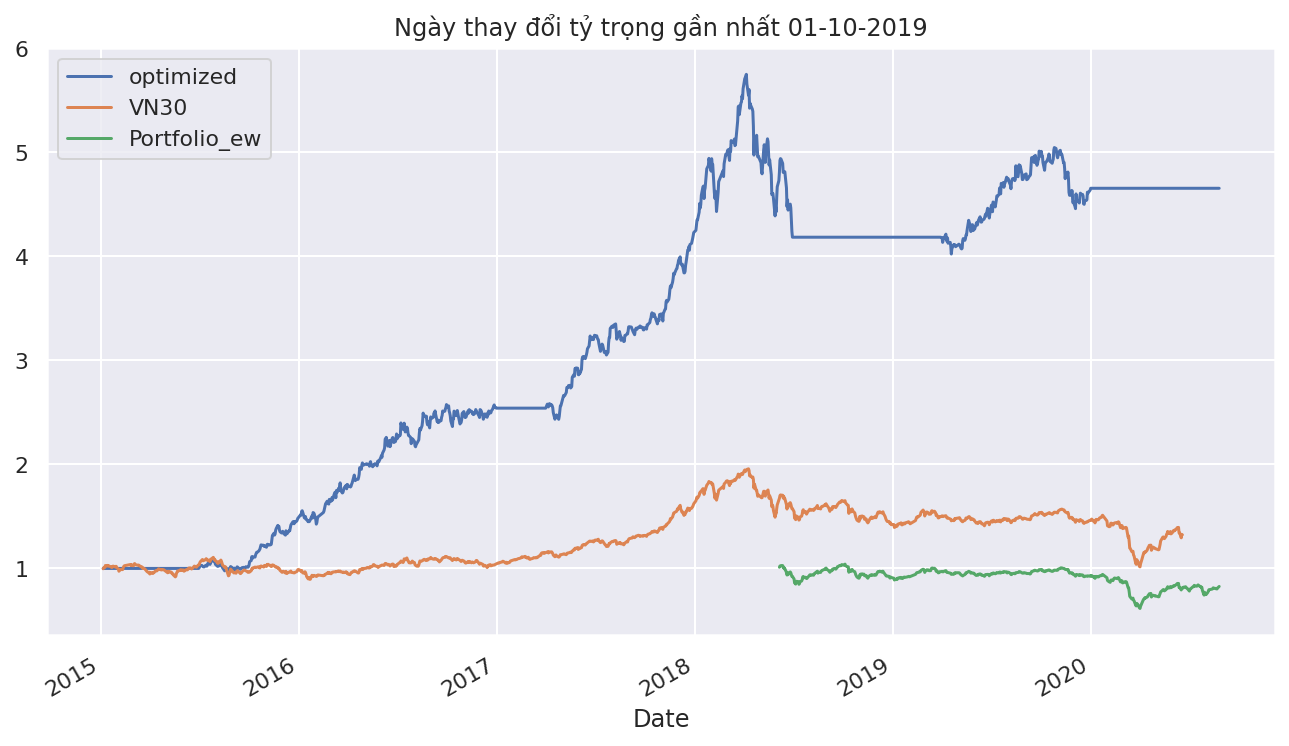

In [586]:
last_reb_date = weights_dfs.Date.max().strftime('%d-%m-%Y')  #, %r
(combine_portfolio+1).cumprod().plot(title="Ngày thay đổi tỷ trọng gần nhất {}".format(last_reb_date))

fig1 = plt.gcf()
fig1.set_size_inches(11,6)
fig1.savefig('mkw.jpg',dpi=120,bbox_inches='tight')

In [587]:

#weights_dfs.to_csv("vn30_optimized_weights.csv")
#weights_dfs.tail(30)

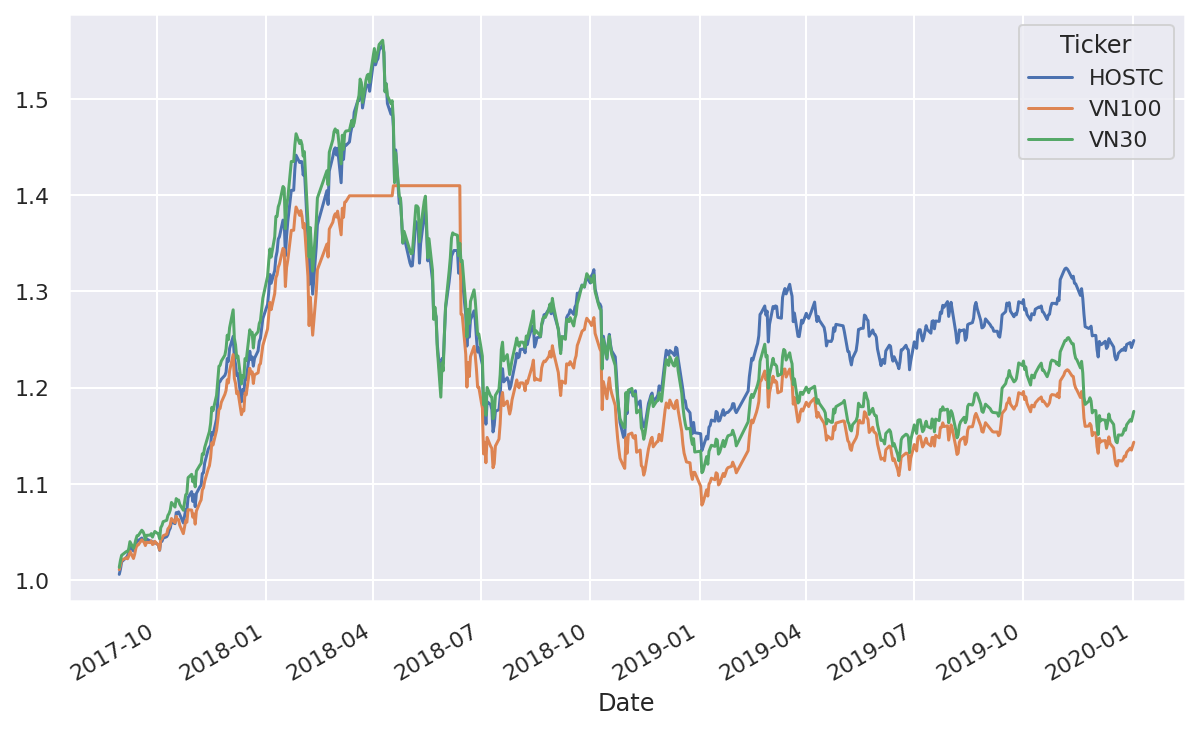

In [588]:
# so sánh index
index_price = pd.read_excel('/content/drive/My Drive/data_analyst/index_price.xlsx')[['Date','Ticker', 'Close']]
index_pivot = index_price.pivot(index="Date", columns="Ticker", values="Close")
index_pivot = index_pivot['2017-08-29':'2020-01-02'][['HOSTC', 'VN100', 'VN30']]
index_pivot
return_index = index_pivot.pct_change()
#return_index['VN100'].dropna()
cum_ret = (return_index + 1).cumprod().dropna()
cum_ret.plot()
#return_index[['HOSTC', 'VN100', 'VN30', 'VNALL']].cumprod()

In [589]:
#end 

In [590]:
#firebase 
import datetime
import threading
from time import sleep

import requests
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from firebase_admin import storage

# Use a service account

# cred = credentials.Certificate("/content/drive/My Drive/data_analyst/service-key-flask-api.json")

# cred = credentials.Certificate("/content/drive/My Drive/data_analyst/service-key.json") #real-time-db
# firebase_admin.initialize_app(cred, {
#     'storageBucket': 'test-realtime-db-ca644.appspot.com'
# })
# db = firestore.client()
# bucket = storage.bucket()

In [591]:
# xử lý weights để push lên
weights_dfs
weight_push = weights_dfs[weights_dfs['Date'] == weights_dfs.Date.max()][['Ticker', 'weights']].set_index('Ticker')
weight_dict = weight_push.to_dict()
weight_dict['weights']

{'BID': 0.0191,
 'BVH': 0.01509,
 'MWG': 0.57162,
 'VIC': 0.03105,
 'VJC': 0.16134,
 'VPB': 0.2018}

In [592]:
doc_ref = db.collection('list1').document('weights')
doc_ref.set(
    weight_dict['weights']
)

update_time {
  seconds: 1599537367
  nanos: 824602000
}

In [593]:
imageBlob = bucket.blob("mkw.jpg")
imageBlob.upload_from_filename("/content/mkw.jpg")
print(imageBlob.public_url)

https://storage.googleapis.com/test-realtime-db-ca644.appspot.com/mkw.jpg


In [594]:
doc_ref = db.collection('lists')
docs = doc_ref.stream()

for doc in docs:
    print(f'{doc.id} => {doc.to_dict()}')

list1 => {'user_id': '1', 'name': 'Longterm invest'}
list2 => {}
stock-item1 => {'item1': 'VCB', 'item2': 'DHG'}


In [595]:
#test từ dưới
#data_index[data_index['Ticker']=='HPG']

In [596]:
#K
a= data_index[data_index['Ticker'].isin(['BID', 'VIC', 'VCB'])]
a=a[(a['Date'] >= '2015-01-01') & (a['Date'] <='2020-01-02')]
a['Close_adj'] = a['Close']/ a['AdjRatio']
a['ret'] = a.groupby('Ticker')['Close_adj'].apply(lambda x: (x/x.shift(1)) - 1).copy()
((a.groupby('Ticker')['ret'].mean())  / a.groupby('Ticker')['ret'].std() ) * np.sqrt(252)

Ticker
BID    1.001074
VCB    1.098738
VIC    1.386827
Name: ret, dtype: float64

In [597]:
import pandas as pd
print(pd.__version__)
import cvxpy as cp
print(cp.__version__)
import numpy as np

1.0.5
1.1.0


In [598]:
a =  {"tiker": ["A","B","A", "B"], "price": [12, 14, 15,18], "w1":[.5, .5, .6, .4], "group": ["G1", "G1", "G2", "G2"]}
b = pd.DataFrame(a)

In [599]:
b.groupby("group").apply(lambda row: (row['w1'] * row['price']).sum())

group
G1    13.0
G2    16.2
dtype: float64

In [600]:
list(index_price)

['Date', 'Ticker', 'Close']

In [601]:
import json
import pandas as pd
df = pd.DataFrame(
    [["a", "b"], ["c", "d"]],
    index=["row 1", "row 2"],
    columns=["col 1", "col 2"],
)
df

#dict(df.groupby("col 1")["col 2"].apply(list))

,col 1,col 2
row 1,a,b
row 2,c,d


In [602]:
#chuẩn to_dict tạo list
# df = pd.read_csv('a.csv')
# print(df)
# df_groupby = df.groupby(['port_id', 'user_id', 'created_date', 'name'])['assets', 'weights'].agg(lambda x: list(x)).reset_index(level=['user_id', 'created_date', 'name'])
# df_groupby.to_dict('index')

In [603]:
# clean_weights
weights_df = pd.DataFrame({"weights": list(cleaned_weights.values()), "Ticker": list(cleaned_weights.keys())})

In [ ]:
#{k: list(v) for k, v in df.groupby(['port_id', 'user_id'])['assets']}

In [ ]:
# đang làm
class City(object):
    def __init__(self, name, user_id, created_date, rebalance=False, rebnum=0,
                 weights={}):
        self.name = name
        self.user_id = user_id
        self.created_date = created_date
        self.rebalance = rebalance
        self.rebnum = rebnum
        self.weights = weights

    @staticmethod
    def from_dict(source):
        # [START_EXCLUDE]
        city = City(source['name'], source['user_id'], source['created_date'])

        if 'rebalance' in source:
            city.rebalance = source['rebalance']

        if 'rebnum' in source:
            city.rebnum = source['rebnum']

        if 'weights' in source:
            city.weights = source['weights']

        return city
        # [END_EXCLUDE]

    def to_dict(self):
        # [START_EXCLUDE]
        dest = {
            'name': self.name,
            'user_id': self.user_id,
            'created_date': self.created_date
        }

        if self.rebalance:
            dest['rebalance'] = self.rebalance

        if self.rebnum:
            dest['rebnum'] = self.rebnum

        if self.weights:
            dest['weights'] = self.weights

        return dest
        # [END_EXCLUDE]

    def __repr__(self):
        return(
            f'City(\
                name={self.name}, \
                created_date={self.created_date}, \
                rebnum={self.rebnum}, \
                rebalance={self.rebalance}, \
                weights={self.weights}\
            )'
        )
# [END custom_class_def]


def add_example_data():
    #db = firestore.Client()
    # [START add_example_data]
    cities_ref = db.collection(u'lists')
    cities_ref.document('list1').set(
        City('LTI', 1, u'2020-09-07', True, 3, {"VCB": 0.3}).to_dict())
    cities_ref.document('list2').set(
        City('Blah', 2, '2020-09-07', False, 0,
             {}).to_dict())
    cities_ref.document('list3').set(
        City('Blah', 1, '2020-09-07', True, 4,
             {}).to_dict())
    cities_ref.document('1').set(
        City('Blah', 1, '2020-09-07', True, 4,
             {}).to_dict())    
    # [END add_example_data]
add_example_data() 